# HTA figs of varying horizontal resolutions
Coarse graining the tracer fields to varying resolutions to determine the effect of scales on the HTA

## Table Of Contents: <a class="anchor" id="top"></a>

* [Calculate HTA for various resolutions](#first-bullet)
* [Plot HTA for each resolution](#second-bullet)
* [Basin-wide annual-mean](#third-bullet)

In [1]:
from dask_gateway import Gateway
gateway = Gateway()
options = gateway.cluster_options()

# set the options programatically, or through their HTML repr
options.worker_memory = 30  # 10 GB of memory per worker.

# Create a cluster with those options
cluster = gateway.new_cluster(options)
cluster.scale(30)
client = cluster.get_client()

In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/staging.303bf53769214a0baa1013580365f28e/status,


In [116]:
client.close()
cluster.close()

In [3]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
import json
import fsspec
import gcsfs
import gcm_filters
import pop_tools

In [4]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
cesm  = cat["CESM_POP_hires_control"].to_dask()
#workaround from Julius to make gradient func work quicker
ds_drop = cesm.drop([v for v in cesm.coords if v not in ['DXT', 'DXU', 'DYT', 'DYU', 'time']])

import json
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

filtered_res = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/filtered_res.zarr'))

# 1) Calculate HTA for various resolutions <a class='anchor' id='first-bullet'></a>

In [6]:
time_slice = dict(time=slice(0, 365)) #first year

#assigning same attrs to the coars res da's so that pop-grid can work on every variable
ds_1 = xr.merge([ds_drop.SST.isel(**time_slice).rename('SST'), ds_drop.SSS.isel(**time_slice).rename('SSS'),
                 filtered_res.SST_10km.rename('SST_10km').assign_attrs(ds_drop.SST.attrs), 
                 filtered_res.SST_100km.rename('SST_100km').assign_attrs(ds_drop.SST.attrs),
                 filtered_res.SSS_10km.rename('SSS_10km').assign_attrs(ds_drop.SSS.attrs), 
                 filtered_res.SSS_100km.rename('SSS_100km').assign_attrs(ds_drop.SSS.attrs)])

In [7]:
ds = ds_1.assign_coords({'nlat':cesm.nlat, 'nlon':cesm.nlon})
ds

<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, time: 365)
Coordinates: (12/43)
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
  * time                (time) object 0046-01-02 00:00:00 ... 0047-01-01 00:0...
    HTE                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    sflux_factor        float64 0.0
    sound               float64 0.0
    stefan_boltzmann    float64 0.0
    vonkar              float64 0.0
  * nlat                (nlat) int64 0 1 2 3 4 5 ... 2395 2396 2397 2398 2399
  * nlon                (nlon) int64 0 1 2 3 4 5 ... 3595 3596 3597 3598 3599
Data variables:
    SST                 (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSS                 (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_10km            (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_100km           (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSS_10km            (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSS_100km           (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
Attributes:
    cell_methods:  time: mean
    grid_loc:      2110
    long_name:     Surface Potential Temperature
    units:         degC

In [8]:
import hta

In [9]:
hta_orig_res = hta.horizontal_turner_angle(ds, 'SST', 'SSS')
hta_10km = hta.horizontal_turner_angle(ds, 'SST_10km', 'SSS_10km')
hta_100km = hta.horizontal_turner_angle(ds, 'SST_100km', 'SSS_100km')

In [13]:
hta_orig_res_mean = hta_orig_res.mean('time').load()
hta_10km_mean = hta_10km.mean('time').load()
hta_100km_mean = hta_100km.mean('time').load()

In [47]:
hta_orig = (-hta_orig_res_mean/2)
hta_10km_sign = (-hta_10km_mean/2)
hta_100km_sign = (-hta_100km_mean/2)

# 2) Plot HTA for each resolution <a class='anchor' id='second-bullet'></a>

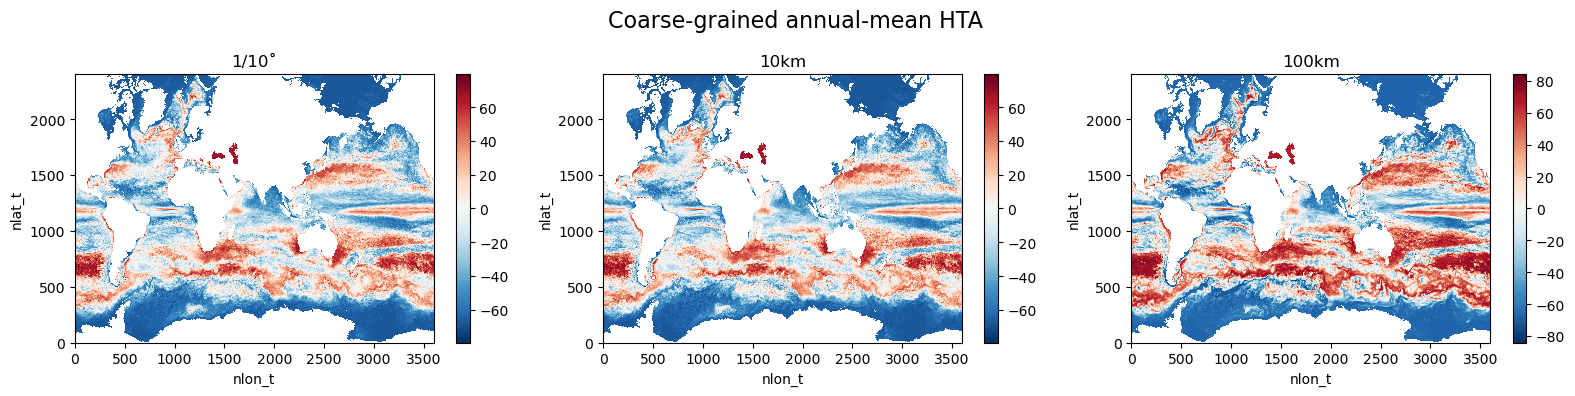

In [48]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))

hta_orig.plot(ax=ax[0])
ax[0].set_title('1/10˚')

hta_10km_sign.plot(ax=ax[1])
ax[1].set_title('10km')

hta_100km_sign.plot(ax=ax[2])
ax[2].set_title('100km')

plt.suptitle('Coarse-grained annual-mean HTA', fontsize=16)
plt.tight_layout();

## Plotting the difference between original resoltuion and coarse

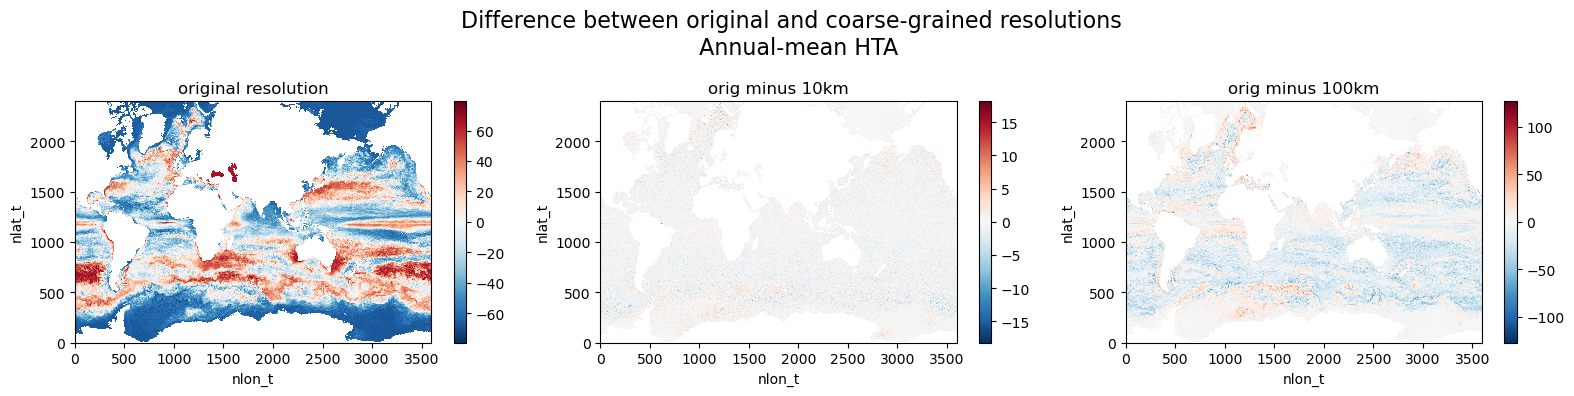

In [81]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))

hta_orig.plot(ax=ax[0])
ax[0].set_title('original resolution')

(hta_orig - hta_10km_sign).plot(ax=ax[1])
ax[1].set_title('orig minus 10km')

(hta_orig - hta_100km_sign).plot(ax=ax[2])
ax[2].set_title('orig minus 100km')

plt.suptitle('Difference between original and coarse-grained resolutions \n Annual-mean HTA', fontsize=16)
plt.tight_layout();

# 3) Basin-wide annual-mean<a class='anchor' id='third-bullet'> </a>

In [52]:
levels = np.arange(-90, 90, 15)

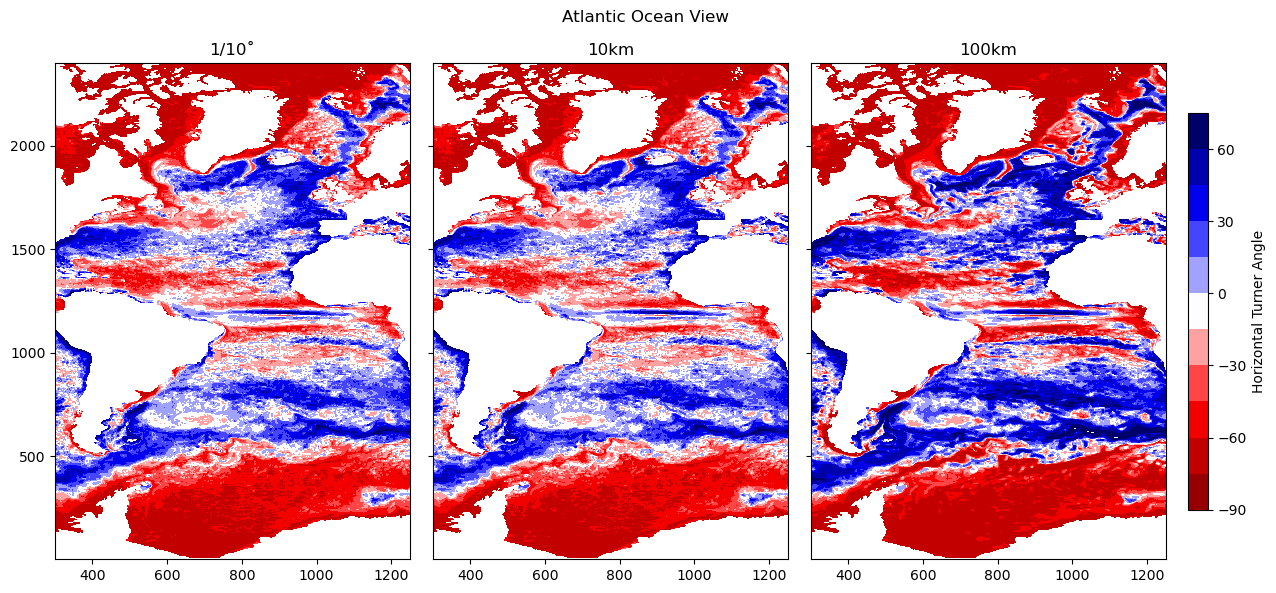

In [64]:
#ATL ocean
fig, ax = plt.subplots(1, 3, figsize=(13,6), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})
sel_lon = dict(nlon_t=slice(300,1250))

ax[0].contourf(hta_orig.nlon_t.isel(**sel_lon), hta_orig.nlat_t, 
               hta_orig.isel(**sel_lon), levels=levels, cmap='seismic_r')
ax[0].set_title('1/10˚')

ax[1].contourf(hta_10km_sign.nlon_t.isel(**sel_lon), hta_10km_sign.nlat_t, 
               hta_10km_sign.isel(**sel_lon), levels=levels, cmap='seismic_r')
ax[1].set_title('10km')

c100 = ax[2].contourf(hta_100km_sign.nlon_t.isel(**sel_lon), hta_100km_sign.nlat_t, 
                      hta_100km_sign.isel(**sel_lon), levels=levels, cmap='seismic_r')
plt.colorbar(c100, shrink=0.8, label='Horizontal Turner Angle', ax=ax[2])
ax[2].set_title('100km')

plt.suptitle('Atlantic Ocean View')
plt.tight_layout();

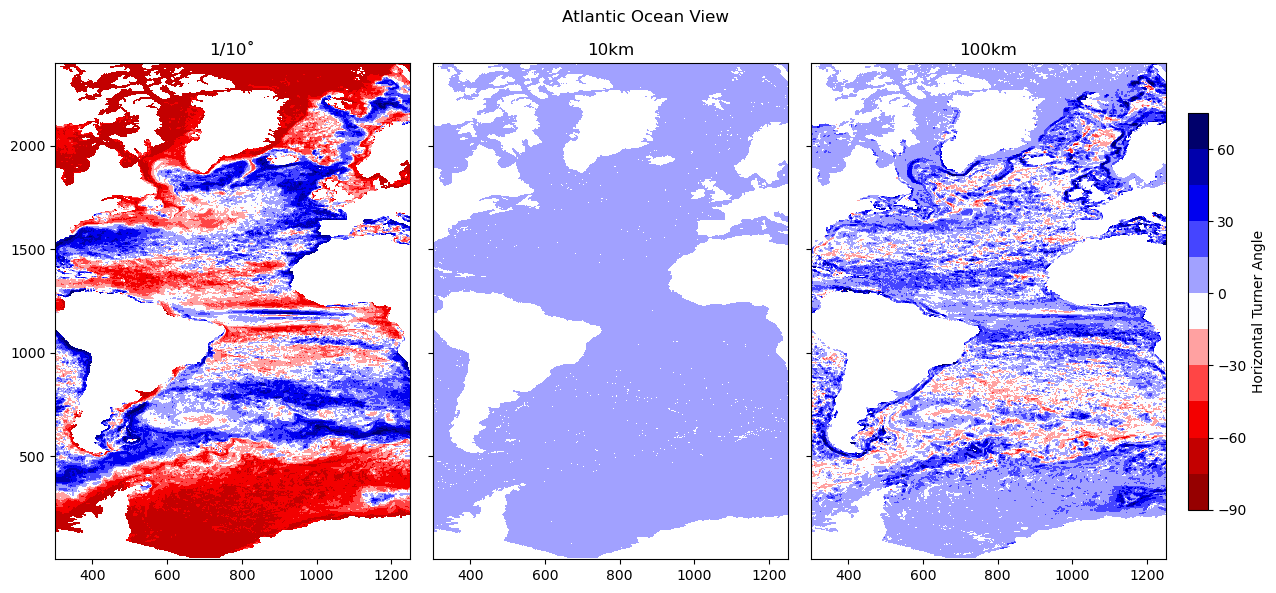

In [82]:
#ATL ocean
fig, ax = plt.subplots(1, 3, figsize=(13,6), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})
sel_lon = dict(nlon_t=slice(300,1250))

ax[0].contourf(hta_orig.nlon_t.isel(**sel_lon), hta_orig.nlat_t, 
               hta_orig.isel(**sel_lon), levels=levels, cmap='seismic_r')
ax[0].set_title('1/10˚')

ax[1].contourf(hta_10km_sign.nlon_t.isel(**sel_lon), hta_10km_sign.nlat_t, 
               (hta_orig - hta_10km_sign).isel(**sel_lon), levels=levels, cmap='seismic_r')
ax[1].set_title('10km')

c100 = ax[2].contourf(hta_100km_sign.nlon_t.isel(**sel_lon), hta_100km_sign.nlat_t, 
                      (hta_orig - hta_100km_sign).isel(**sel_lon), levels=levels, cmap='seismic_r')
plt.colorbar(c100, shrink=0.8, label='Horizontal Turner Angle', ax=ax[2])
ax[2].set_title('100km')

plt.suptitle('Atlantic Ocean View')
plt.tight_layout();

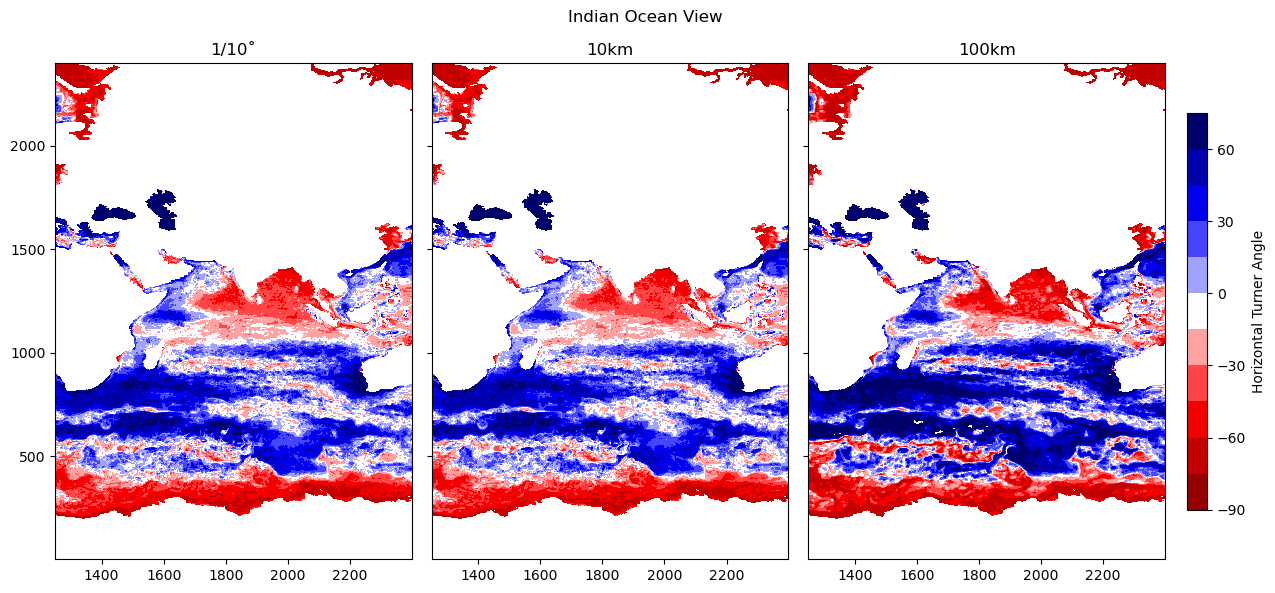

In [65]:
#IND ocean
fig, ax = plt.subplots(1, 3, figsize=(13,6), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})
sel_lon = dict(nlon_t=slice(1250, 2400))

ax[0].contourf(hta_orig.nlon_t.isel(**sel_lon), hta_orig.nlat_t, 
               hta_orig.isel(**sel_lon), levels=levels, cmap='seismic_r')
ax[0].set_title('1/10˚')

ax[1].contourf(hta_10km_sign.nlon_t.isel(**sel_lon), hta_10km_sign.nlat_t, 
               hta_10km_sign.isel(**sel_lon), levels=levels, cmap='seismic_r')
ax[1].set_title('10km')

c100 = ax[2].contourf(hta_100km_sign.nlon_t.isel(**sel_lon), hta_100km_sign.nlat_t, 
                      hta_100km_sign.isel(**sel_lon), levels=levels, cmap='seismic_r')
plt.colorbar(c100, shrink=0.8, label='Horizontal Turner Angle', ax=ax[2])
ax[2].set_title('100km')

plt.suptitle('Indian Ocean View')
plt.tight_layout();

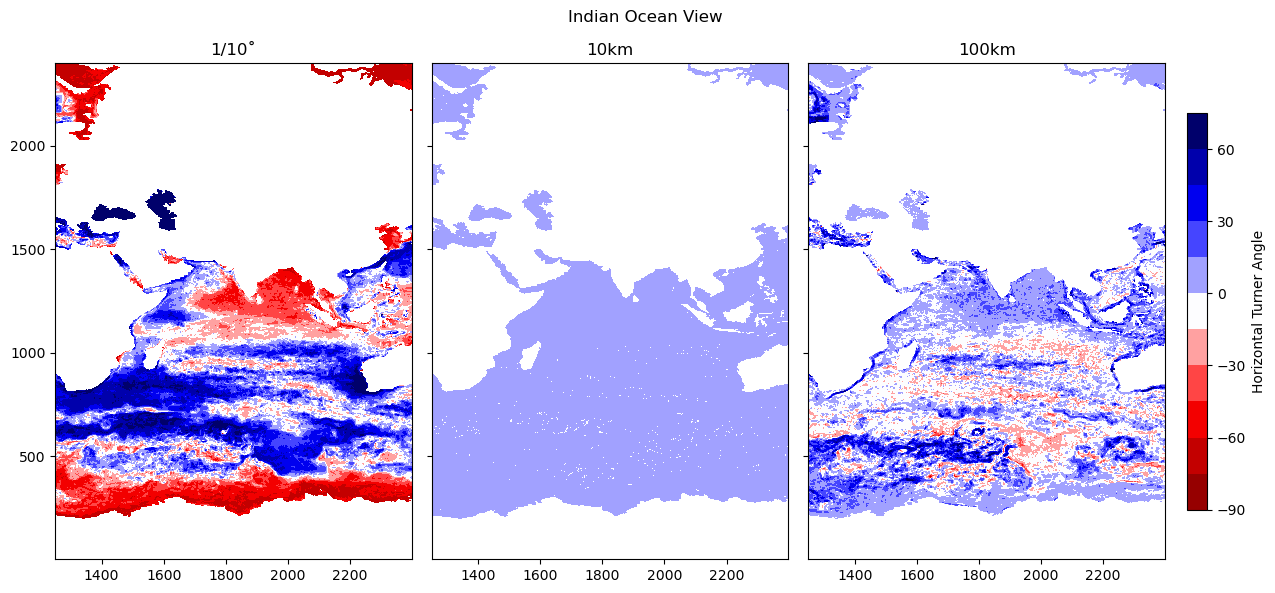

In [83]:
#IND ocean
fig, ax = plt.subplots(1, 3, figsize=(13,6), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})
sel_lon = dict(nlon_t=slice(1250, 2400))

ax[0].contourf(hta_orig.nlon_t.isel(**sel_lon), hta_orig.nlat_t, 
               hta_orig.isel(**sel_lon), levels=levels, cmap='seismic_r')
ax[0].set_title('1/10˚')

ax[1].contourf(hta_10km_sign.nlon_t.isel(**sel_lon), hta_10km_sign.nlat_t, 
               (hta_orig - hta_10km_sign).isel(**sel_lon), levels=levels, cmap='seismic_r')
ax[1].set_title('10km')

c100 = ax[2].contourf(hta_100km_sign.nlon_t.isel(**sel_lon), hta_100km_sign.nlat_t, 
                      (hta_orig - hta_100km_sign).isel(**sel_lon), levels=levels, cmap='seismic_r')
plt.colorbar(c100, shrink=0.8, label='Horizontal Turner Angle', ax=ax[2])
ax[2].set_title('100km')

plt.suptitle('Indian Ocean View')
plt.tight_layout();

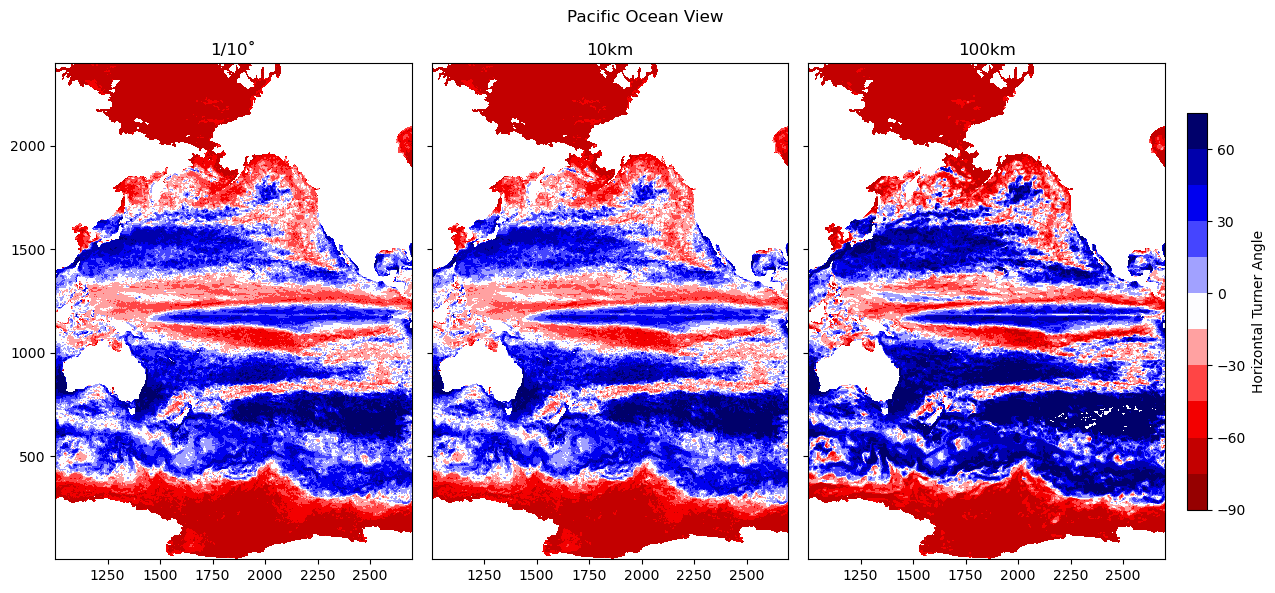

In [77]:
#PAC ocean
fig, ax = plt.subplots(1, 3, figsize=(13,6), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

sel_lon = dict(nlon_t=slice(1000,2700))
hta_orig_roll = hta_orig.roll(nlon_t=2400, roll_coords=False).isel(**sel_lon)
hta_10km_roll = hta_10km_sign.roll(nlon_t=2400, roll_coords=False).isel(**sel_lon)
hta_100km_roll = hta_100km_sign.roll(nlon_t=2400, roll_coords=False).isel(**sel_lon)

ax[0].contourf(hta_orig_roll.nlon_t.drop('nlon_t'), hta_orig_roll.nlat_t, 
               hta_orig_roll.drop('nlon_t'), levels=levels, cmap='seismic_r')
ax[0].set_title('1/10˚')

ax[1].contourf(hta_10km_roll.nlon_t.drop('nlon_t'), hta_10km_roll.nlat_t, 
               hta_10km_roll.drop('nlon_t'), levels=levels, cmap='seismic_r')
ax[1].set_title('10km')

c100 = ax[2].contourf(hta_100km_roll.nlon_t.drop('nlon_t'), hta_100km_roll.nlat_t, 
                      hta_100km_roll.drop('nlon_t'), levels=levels, cmap='seismic_r')
plt.colorbar(c100, shrink=0.8, label='Horizontal Turner Angle', ax=ax[2])
ax[2].set_title('100km')

plt.suptitle('Pacific Ocean View')
plt.tight_layout();

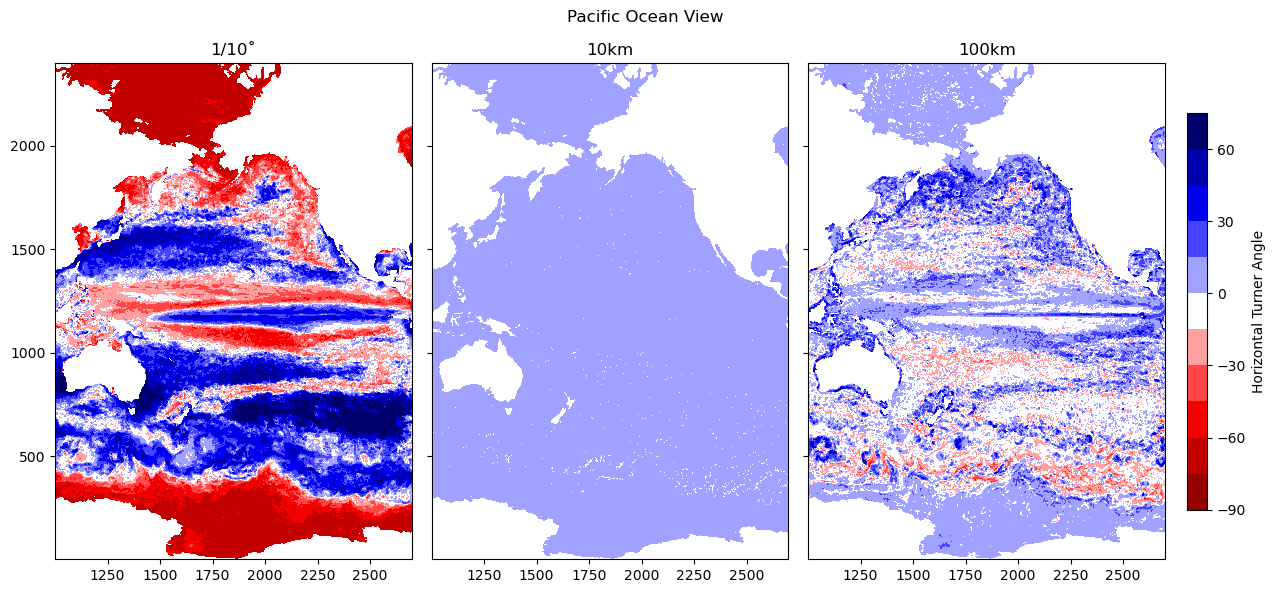

In [84]:
#PAC ocean
fig, ax = plt.subplots(1, 3, figsize=(13,6), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

sel_lon = dict(nlon_t=slice(1000,2700))
hta_orig_roll = hta_orig.roll(nlon_t=2400, roll_coords=False).isel(**sel_lon)
hta_10km_roll = hta_10km_sign.roll(nlon_t=2400, roll_coords=False).isel(**sel_lon)
hta_100km_roll = hta_100km_sign.roll(nlon_t=2400, roll_coords=False).isel(**sel_lon)

ax[0].contourf(hta_orig_roll.nlon_t.drop('nlon_t'), hta_orig_roll.nlat_t, 
               hta_orig_roll.drop('nlon_t'), levels=levels, cmap='seismic_r')
ax[0].set_title('1/10˚')

ax[1].contourf(hta_10km_roll.nlon_t.drop('nlon_t'), hta_10km_roll.nlat_t, 
               (hta_orig_roll - hta_10km_roll).drop('nlon_t'), levels=levels, cmap='seismic_r')
ax[1].set_title('10km')

c100 = ax[2].contourf(hta_100km_roll.nlon_t.drop('nlon_t'), hta_100km_roll.nlat_t, 
                      (hta_orig_roll - hta_100km_roll).drop('nlon_t'), levels=levels, cmap='seismic_r')
plt.colorbar(c100, shrink=0.8, label='Horizontal Turner Angle', ax=ax[2])
ax[2].set_title('100km')

plt.suptitle('Pacific Ocean View')
plt.tight_layout();

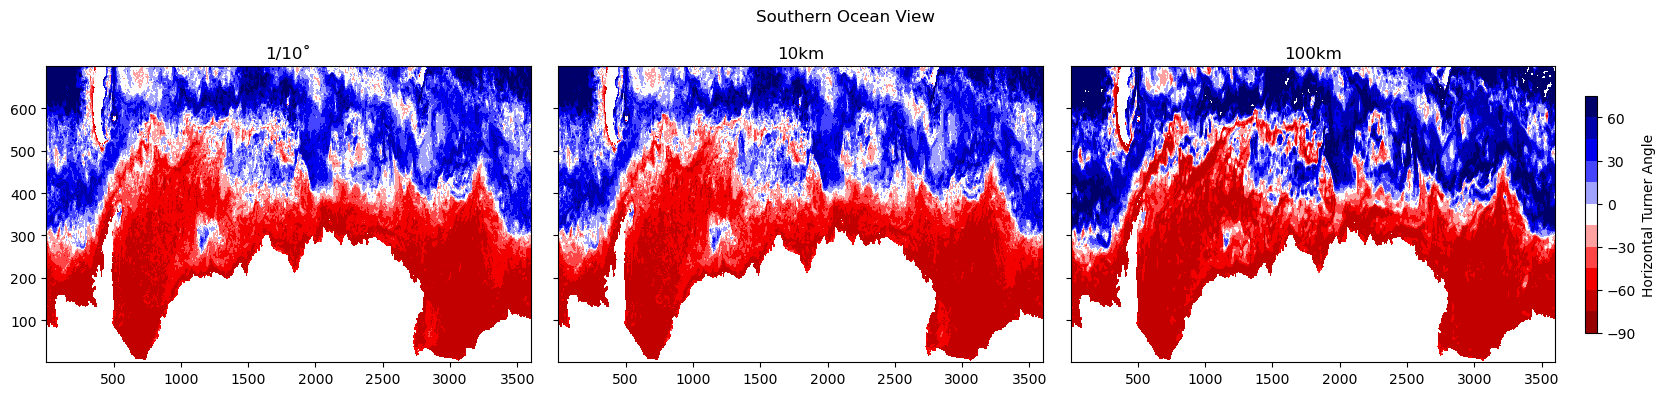

In [68]:
#SO ocean
fig, ax = plt.subplots(1, 3, figsize=(17,4), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})
sel_lat = dict(nlat_t=slice(0, 700))

ax[0].contourf(hta_orig.nlon_t, hta_orig.nlat_t.isel(**sel_lat), 
               hta_orig.isel(**sel_lat), levels=levels, cmap='seismic_r')
ax[0].set_title('1/10˚')

ax[1].contourf(hta_10km_sign.nlon_t, hta_10km_sign.nlat_t.isel(**sel_lat), 
               hta_10km_sign.isel(**sel_lat), levels=levels, cmap='seismic_r')
ax[1].set_title('10km')

c100 = ax[2].contourf(hta_100km_sign.nlon_t, hta_100km_sign.nlat_t.isel(**sel_lat), 
                      hta_100km_sign.isel(**sel_lat), levels=levels, cmap='seismic_r')
plt.colorbar(c100, shrink=0.8, label='Horizontal Turner Angle', ax=ax[2])
ax[2].set_title('100km')

plt.suptitle('Southern Ocean View')
plt.tight_layout();

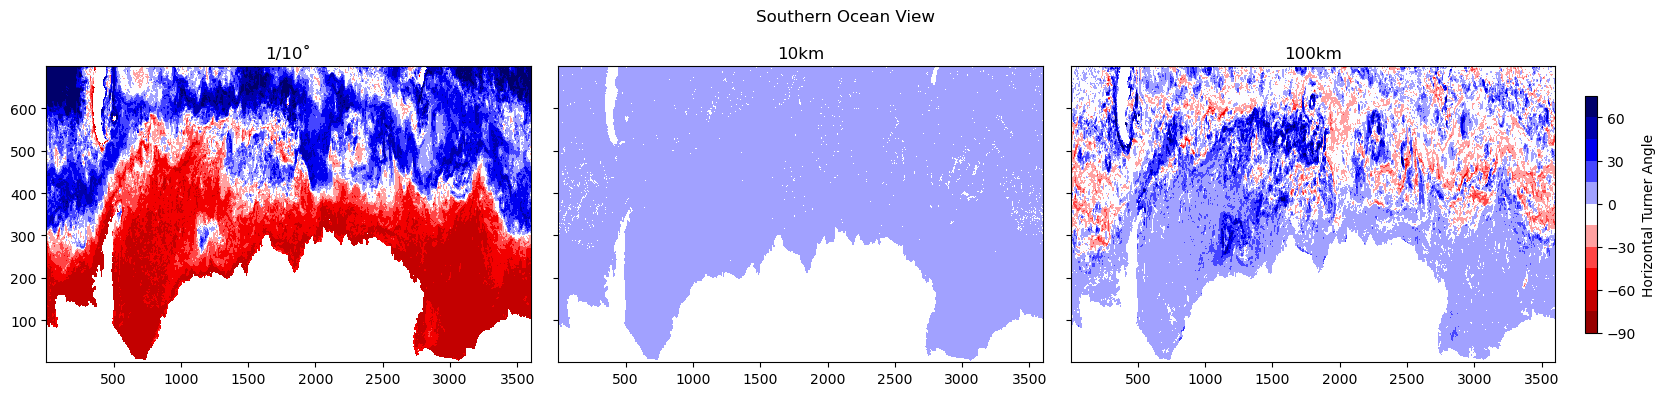

In [85]:
#SO ocean
fig, ax = plt.subplots(1, 3, figsize=(17,4), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})
sel_lat = dict(nlat_t=slice(0, 700))

ax[0].contourf(hta_orig.nlon_t, hta_orig.nlat_t.isel(**sel_lat), 
               hta_orig.isel(**sel_lat), levels=levels, cmap='seismic_r')
ax[0].set_title('1/10˚')

ax[1].contourf(hta_10km_sign.nlon_t, hta_10km_sign.nlat_t.isel(**sel_lat), 
               (hta_orig - hta_10km_sign).isel(**sel_lat), levels=levels, cmap='seismic_r')
ax[1].set_title('10km')

c100 = ax[2].contourf(hta_100km_sign.nlon_t, hta_100km_sign.nlat_t.isel(**sel_lat), 
                      (hta_orig - hta_100km_sign).isel(**sel_lat), levels=levels, cmap='seismic_r')
plt.colorbar(c100, shrink=0.8, label='Horizontal Turner Angle', ax=ax[2])
ax[2].set_title('100km')

plt.suptitle('Southern Ocean View')
plt.tight_layout();